<center><img src="images/clothing.jpg"></center>

Welcome to the world of e-commerce, where customer feedback is a goldmine of insights! In this project, you'll dive into the Women's Clothing E-Commerce Reviews dataset, focusing on the 'Review Text' column filled with direct customer opinions.

Your mission is to use text embeddings and Python to analyze these reviews, uncover underlying themes, and understand customer sentiments. This analysis will help improve customer service and product offerings.

## The Data

You will be working with a dataset specifically focusing on customer reviews. Below is the data dictionary for the relevant field:

## womens_clothing_e-commerce_reviews.csv

| Column        | Description                           |
|---------------|---------------------------------------|
| `'Review Text'` | Textual feedback provided by customers about their shopping experience and product quality. |

Armed with access to powerful embedding API services, you will process the reviews, extract meaningful insights, and present your findings.

Let's get started!

## Before you start

In order to complete the project you will need to create a developer account with OpenAI and store your API key as a secure environment variable. Instructions for these steps are outlined below.

### Create a developer account with OpenAI

1. Go to the [API signup page](https://platform.openai.com/signup). 

2. Create your account (you'll need to provide your email address and your phone number).

3. Go to the [API keys page](https://platform.openai.com/account/api-keys). 

4. Create a new secret key.

<img src="images/openai-new-secret-key.png" width="200">

5. **Take a copy of it**. (If you lose it, delete the key and create a new one.)

### Add a payment method

OpenAI sometimes provides free credits for the API, but this can vary depending on geography. You may need to add debit/credit card details. 

**This project should cost much less than 1 US cents with `gpt-4o-mini` (but if you rerun tasks, you will be charged every time).**

1. Go to the [Payment Methods page](https://platform.openai.com/account/billing/payment-methods).

2. Click Add payment method.

<img src="images/openai-add-payment-method.png" width="200">

3. Fill in your card details.

### Add an environmental variable with your OpenAI key

1. In the workbook, click on "Environment," in the top toolbar and select "Environment variables".

2. Click "Add" to add environment variables.

3. In the "Name" field, type "OPENAI_API_KEY". In the "Value" field, paste in your secret key.

<img src="images/datalab-env-var-details.png" width="500">

4. Click "Create", then you'll see the following pop-up window. Click "Connect," then wait 5-10 seconds for the kernel to restart, or restart it manually in the Run menu.

<img src="images/connect-integ.png" width="500">

### Update to Python 3.10

Due to how frequently the libraries required for this project are updated, you'll need to update your environment to Python 3.10:

1. In the workbook, click on "Environment," in the top toolbar and select "Session details".

2. In the workbook language dropdown, select "Python 3.10".

3. Click "Confirm" and hit "Done" once the session is ready.

## Load OpenAI API key from environment variables
These variables can be referenced globally throughout the project while keeping their values secret. Good for setting passwords in credentials.

In [137]:
# Initialize your API key
import os
openai_api_key = os.environ["OPENAI"]

## Install useful libraries

In [138]:
# Update OpenAI to 1.3
from importlib.metadata import version
try:
    assert version('openai') == '1.3.0' # first check if the installed version of the OpenAI package is 1.3.0
except:
    !pip install openai==1.3.0 # if not, then install v.1.3.0
import openai

In [139]:
# Run this cell to install ChromaDB if desired
try:
    assert version('chromadb') == '0.4.17'
except:
    !pip install chromadb==0.4.17
try:
    assert version('pysqlite3') == '0.5.2'
except:
    !pip install pysqlite3-binary==0.5.2
# The __import__() function dynamically imports a module by name (in this case, 'pysqlite3').
# Normally, we would use import pysqlite3, but this allows for dynamic importing, which can be useful if you want to import a module whose name is stored in a variable or determined at runtime.
# This line ensures that the pysqlite3 module is loaded into the Python environment.
__import__('pysqlite3')
import sys
# This line is essentially replacing the standard sqlite3 module with pysqlite3.
# The goal here is to make pysqlite3 behave like sqlite3.
# Why is this done? - 
# ChromaDB requires the sqlite3 module, but in this case, the code wants to use pysqlite3 (which is a different version of sqlite3 that is optimized for use in some environments).
# By manipulating sys.modules, the code ensures that whenever sqlite3 is imported in the future (like in ChromaDB), it will use pysqlite3 instead.
# This is a way to make pysqlite3 work in place of sqlite3 without changing every import sqlite3 in the codebase.
sys.modules['sqlite3'] = sys.modules.pop('pysqlite3')
import chromadb

Defaulting to user installation because normal site-packages is not writeable


In [140]:
# Import required libraries
import os
import openai
from openai import OpenAI
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import chromadb
from scipy.spatial import distance
from chromadb.utils.embedding_functions import OpenAIEmbeddingFunction

## Load the dataset
Load data and perform basic data checks to ensure you are using relevant data for the analysis

In [141]:
# Load the dataset
reviews = pd.read_csv("womens_clothing_e-commerce_reviews.csv")

# Display the first few entries
reviews.head()

,Review ID,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [142]:
# APPROACH 1: DROPPING MISSING VALUES USING dropna()
review_texts_1 = reviews["Review Text"].dropna().tolist()
len(review_texts_1)

958

In [143]:
## APPROACH 2: DROPPING MISSING VALUES & USING iterrows() - SLOWER. Iterrows() is slow. Avoid.
review_texts_2 = [row["Review Text"] for _, row in reviews.iterrows() if pd.notna(row["Review Text"])]
len(review_texts_2)

958

In [144]:
# APPROACH 3: Most efficient way. NOTE: Indexes are not reset. Will use the index later.
review_texts = reviews.loc[reviews["Review Text"].notna(), "Review Text"].tolist()
len(review_texts)

958

## PART 1: Create and store the embeddings
Embed the reviews using a suitable text embedding algorithm and store them as list in the variable embeddings.

In [145]:
EMBEDDING_MODEL = "text-embedding-ada-002"
client = OpenAI(api_key=openai_api_key)

In [146]:
# Create and store the embeddings for reviews in one API call
def create_embeddings(texts):
    responses = client.embeddings.create( # calls OpenAI API - paid call
        model=EMBEDDING_MODEL,
        input=texts
    ).model_dump()
    return [response["embedding"] for response in responses["data"]]
embeddings = create_embeddings(review_texts)

In [147]:
print(len(embeddings))
print(len(embeddings[0]))

958
1536


## PART 2: Dimensionality reduction & visualization
- Apply an appropriate dimensionality reduction technique to reduce the embeddings to a 2-dimensional numpy array and store this array in the variable embeddings_2d.
- Then, use this variable to plot a 2D visual representation of the reviews.

In [148]:
# Apply t-SNE for dimensionality reduction
def apply_tsne(embeddings):
    tsne = TSNE(n_components=2, random_state=0) # using default perplexity = 30
    return tsne.fit_transform(embeddings)

embeddings_2d = apply_tsne(np.array(embeddings))

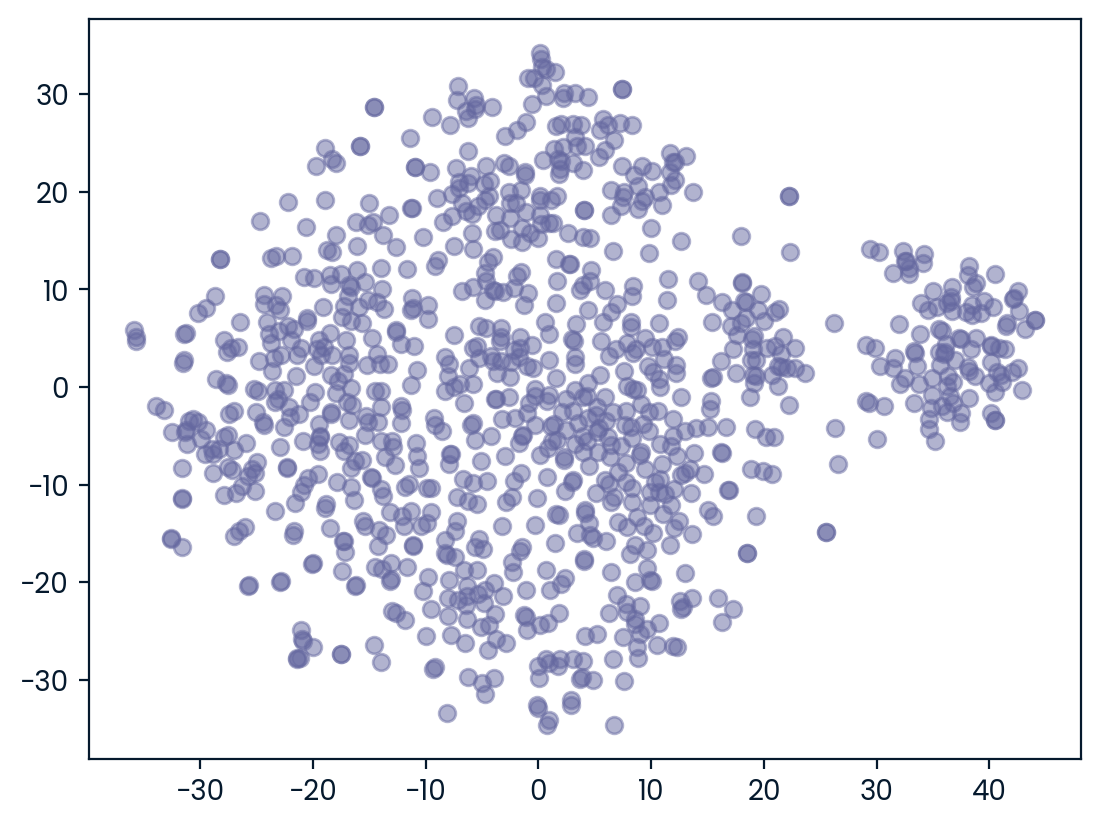

In [149]:
# Plotting a simple scatterplot without any data point annotations
plt.scatter(embeddings_2d[:,0],embeddings_2d[:,1], alpha=0.5)

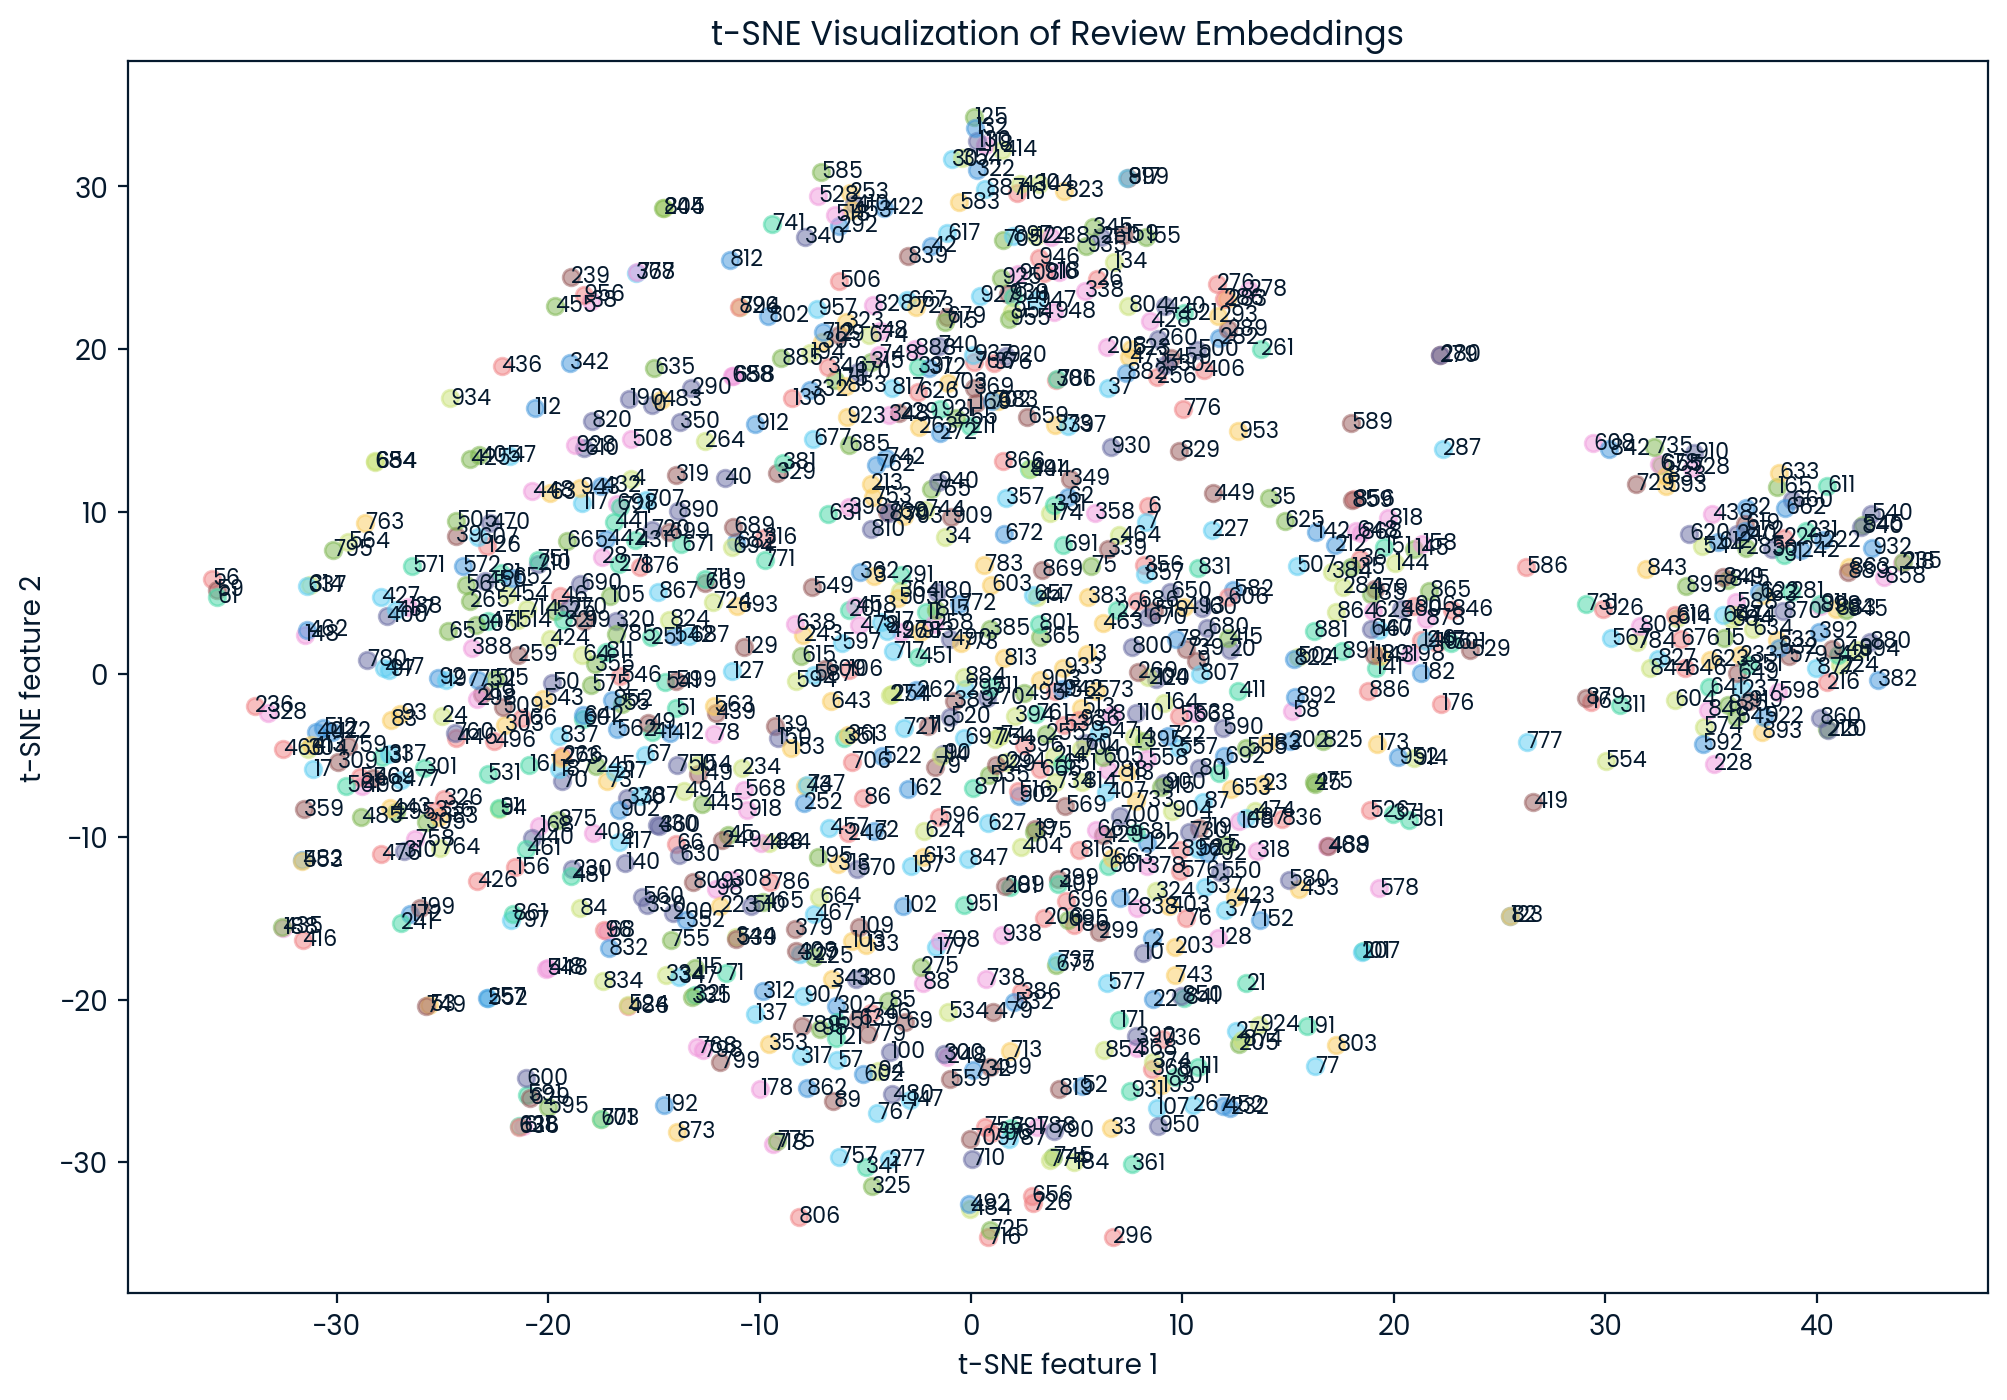

In [150]:
# same plot as above vut a little more fancy with annotations
# Plotting the results of t-SNE
def plot_tsne(tsne_results):
    plt.figure(figsize=(12, 8))
    for i, point in enumerate(tsne_results):
        plt.scatter(point[0], point[1], alpha=0.5)
        plt.text(point[0], point[1], str(i), fontsize=8, verticalalignment='center')
    plt.title("t-SNE Visualization of Review Embeddings")
    plt.xlabel("t-SNE feature 1")
    plt.ylabel("t-SNE feature 2")
    plt.show()

plot_tsne(embeddings_2d)

## PART 3: Feedback categorization
Use your embeddings to identify some reviews that discuss topics such as 'quality', 'fit', 'style', 'comfort', etc.

In [151]:
# Define topics
categories = ["Quality", "Fit", "Style", "Comfort"]

In [152]:
# Create embeddings for all categories in one API call
#category_responses = client.embeddings.create(input=categories, model=EMBEDDING_MODEL).model_dump()
# Extract embeddings from the responses and map them to their respective categories
#category_embeddings = [embedding["embedding"] for embedding in category_responses["data"]]

# OR using the custom function

category_embeddings = create_embeddings(categories)

In [153]:
print(len(category_embeddings))
print(len(category_embeddings[0]))

4
1536


In [154]:
# Function to categorize feedback
def categorize_feedback(text_embedding, category_embeddings):
    similarities = [{"distance": distance.cosine(text_embedding, cat_emb), "index":i}
                     for i, cat_emb in enumerate(category_embeddings)]
    closest = min(similarities, key=lambda x: x["distance"])
    return categories[closest["index"]]

In [155]:
# Categorize feedback
feedback_categories = [categorize_feedback(embedding, category_embeddings) for embedding in embeddings]

In [156]:
# each review is categozed into one of the 4 categories, we can merge this list to the review_texts list and check reviews for each of the 4 categories (as below)
print(len(feedback_categories))
print(set(feedback_categories))

958
{'Comfort', 'Quality', 'Fit', 'Style'}


In [157]:
# Create DataFrame
categorized_df = pd.DataFrame({"Review Text": review_texts, "Feedback Category": feedback_categories})
categorized_df.head()

,Review Text,Feedback Category
0,Absolutely wonderful - silky and sexy and comf...,Comfort
1,Love this dress! it's sooo pretty. i happene...,Fit
2,I had such high hopes for this dress and reall...,Fit
3,"I love, love, love this jumpsuit. it's fun, fl...",Fit
4,This shirt is very flattering to all due to th...,Fit


### Another way to tackle the above feedback categorization problem is do a semantic search (without using a vector database) as below

In [158]:
query_text = "quality, fit, style, comfort" # search for reviews that matches all 4 keywords semantically
query_vector = create_embeddings(query_text)[0]

In [159]:
def find_n_closest(query_vector, embeddings, n=3):
    distances = []
    distances = [{"distance": distance.cosine(query_vector, embedding), "index":i}
                     for i, embedding in enumerate(embeddings)]
    closest = sorted(distances, key=lambda x: x["distance"])
    return closest[0:n]

In [160]:
hits = find_n_closest(query_vector,embeddings)

In [161]:
hits

[{'distance': 0.14240238471486077, 'index': 478},
 {'distance': 0.15069307472641225, 'index': 190},
 {'distance': 0.1543325622737809, 'index': 47}]

In [162]:
for hit in hits:
    print(review_texts[hit['index']],"\n")

Very cute, very comfortable. for me aesthetics and comfort must go hand in hand. this dress fits the bill. 

For a now feel, that comfy and well made, this was a great choice! 

Very comfortable, material is good, cut out on sleeves flattering 



## PART 4: Similarity search function (using a vector database - ChromaDB)
- Write a function that outputs the closest 3 reviews to a given input review, enabling a more personalized customer service response.
- Apply this function to the first review "Absolutely wonderful - silky and sexy and comfortable", and store the output as a list in the variable most_similar_reviews.

In [163]:
# Initialize Chromadb instance for vector storage
client = chromadb.PersistentClient()

In [164]:
# Define vector database
review_embeddings_db = client.create_collection(
    name="review_embeddings",
    embedding_function=OpenAIEmbeddingFunction(api_key=openai_api_key)) # the default embedding model used is “text-embedding-ada-002”, which we had used for our embedding without a vector database


In [165]:
len(review_texts)

958

In [166]:
# Store embeddings inside vector database
review_embeddings_db.add(
    documents=review_texts,
    ids=[str(i) for i in range(len(review_texts))]
)

In [167]:
# Function for similarity search using vector db query function
def find_similar_reviews(input_text, vector_db, n=3):
    # either we can get_collection using the collection name or use the passed vector_db as collection
    collection = client.get_collection(
        name="review_embeddings",
        embedding_function=OpenAIEmbeddingFunction(api_key=openai_api_key)) # the default embedding model used is “text-embedding-ada-002”
    results = collection.query(
        query_texts=[input_text], # input is passed as list
        n_results=n
    )
    return results

In [168]:
# Example feedback and finding similar feedback
example_review = "Absolutely wonderful - silky and sexy and comfortable"
most_similar_reviews = find_similar_reviews(example_review, review_embeddings_db, 3)["documents"][0]

In [169]:
for most_similar_review in most_similar_reviews:
    print(most_similar_review, "\n")

Absolutely wonderful - silky and sexy and comfortable 

Very comfortable and versatile. got lots of compliments. 

Very comfortable, material is good, cut out on sleeves flattering 



In [170]:
# Clean up
client.delete_collection(name="review_embeddings")